# Loss Landscapes for CNNs
In this notebook, we show how Landscaper can be used to analyze a CNN trained on the CIFAR-10 dataset. 
(From https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
# might have issues with too many files being opened at once, this will prevent that
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [4]:
# Check if CUDA is available
device = "cpu"

In [5]:
# load in the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [6]:
# setup the model
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.177
[1,  4000] loss: 1.888
[1,  6000] loss: 1.716
[1,  8000] loss: 1.573
[1, 10000] loss: 1.511
[1, 12000] loss: 1.463
[2,  2000] loss: 1.404
[2,  4000] loss: 1.384
[2,  6000] loss: 1.338
[2,  8000] loss: 1.335
[2, 10000] loss: 1.309
[2, 12000] loss: 1.304
Finished Training


In [9]:
PATH = './cifar_net.pth'

In [10]:
torch.save(net.state_dict(), PATH)

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [12]:
trunc_data = []
for idx, d in enumerate(testloader):
    trunc_data.append(d)    
    if idx > 5:
        break

# Analyzing the loss landscape

In [13]:
# subclass PyHessian to work with our dataset
from landscaper.utils import get_params_grad
from pyhessian.hessian import PyHessian
class CNNHessian(PyHessian):
    def __init__(self, model, criterion, data=None, dataloader=None, cuda=True):
        """
        model: the model that needs Hessain information
        criterion: the loss function
        data: a single batch of data, including inputs and its corresponding labels
        dataloader: the data loader including bunch of batches of data
        """
        super().__init__(model, criterion, data, dataloader, cuda)

        inputs = []
        labels = []
        for idx, d in enumerate(dataloader, 0):
            i, l = d
            inputs.append(i)
            labels.append(l)

            
        self.inputs = inputs
        self.targets = labels
        self.model.train()
        with torch.backends.cudnn.flags(enabled=False):
            for i in zip(self.inputs, self.targets):
                d, t = i
                outputs = self.model(d)
                loss = self.criterion(outputs, t)
                loss.backward(create_graph=True)
        
        params, gradsH = get_params_grad(self.model)
        self.params = params
        self.gradsH = gradsH  # gradient used for Hessian computation

In [18]:
hessian_comp = CNNHessian(net, criterion, dataloader = trunc_data, cuda=False)

In [19]:
def loss_function(model, data):
    batch_loss = 0
    for d in data: 
        tt, lbl_t = d
        output = model.forward(tt)
        loss = criterion(output, lbl_t)
        batch_loss += loss
    return batch_loss

In [20]:
from landscaper.landscape import LossLandscape

In [21]:
with torch.backends.cudnn.flags(enabled=False):
    landscape = LossLandscape.compute(
    net,
    trunc_data,
    hessian_comp,
    loss_function, # loss function
    dim=2,
    device=device,
)

Top 10 eigenvalues: [20.65976905822754, 18.975460052490234, 14.944342613220215, 14.375399589538574, 11.822978019714355, 8.976461410522461, 8.66464614868164, 7.984944820404053, 6.901398181915283, 6.508577823638916]
Computing 1681 points in 2D space...


Computing 2D landscape: 100%|████████████████████████████████████████████████| 169/169 [00:05<00:00, 33.04it/s]

Loss hypercube stats - min: 1434.1865234375, max: 1894.515380859375, mean: 1654.474898756437


In [22]:
landscape.save("cnn.npz")

In [23]:
landscape  = LossLandscape.load_from_npz("cnn.npz")

Attempting log-scale surface plot...


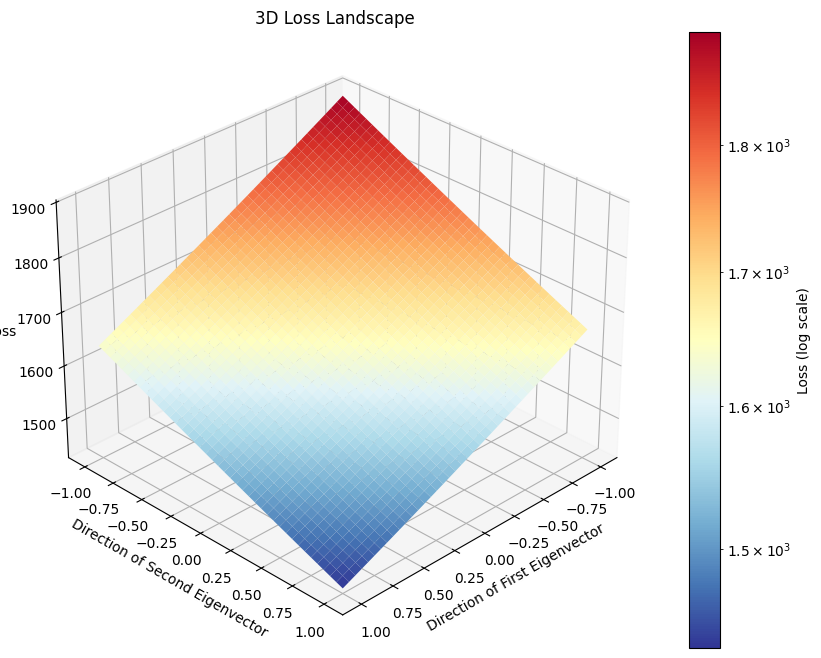

In [24]:
landscape.show()

X-axis range: 0.0, 1681.0
Y-axis range: 0.0, 1894.515380859375


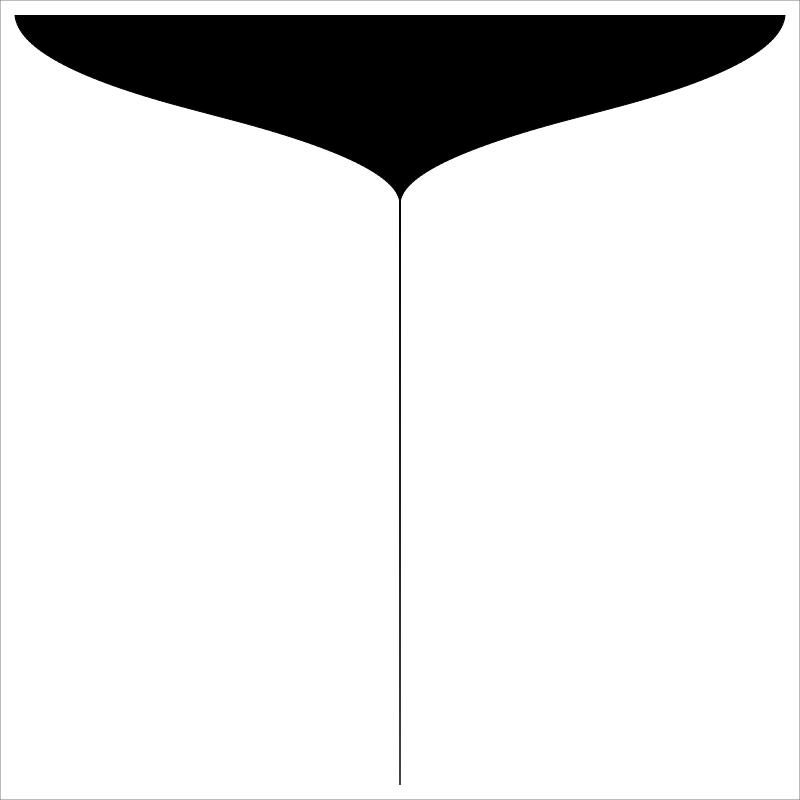

In [25]:
landscape.show_profile()

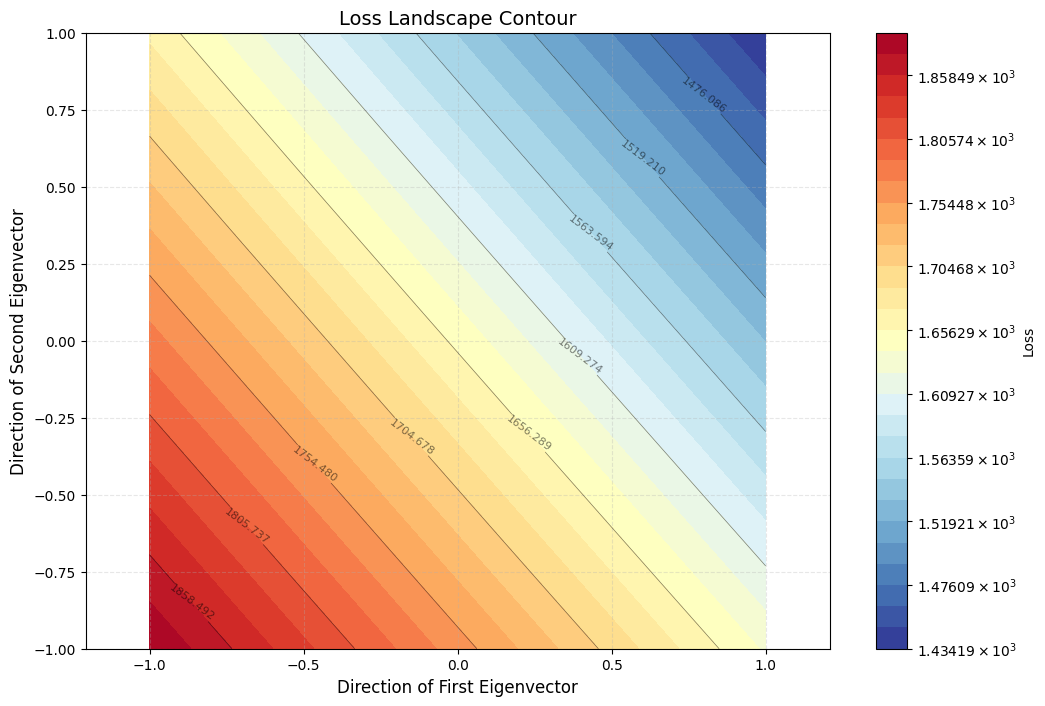

In [26]:
landscape.show_contour()

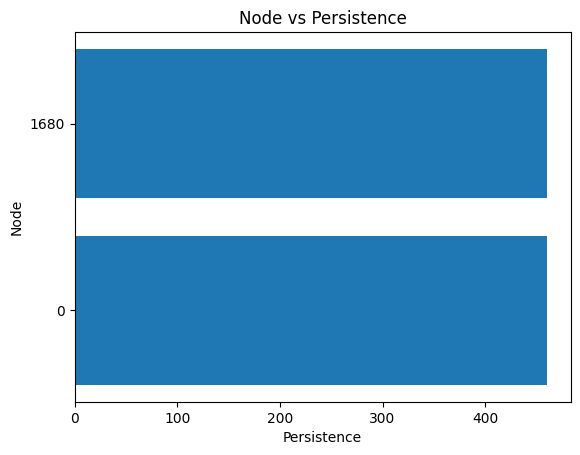

In [27]:
landscape.show_persistence_barcode()

In [28]:
# we can use this function to convert the merge tree 
# into a networkx graph and visualize it!
from landscaper.tda import merge_tree_to_nx
g = merge_tree_to_nx(landscape.get_sublevel_tree())

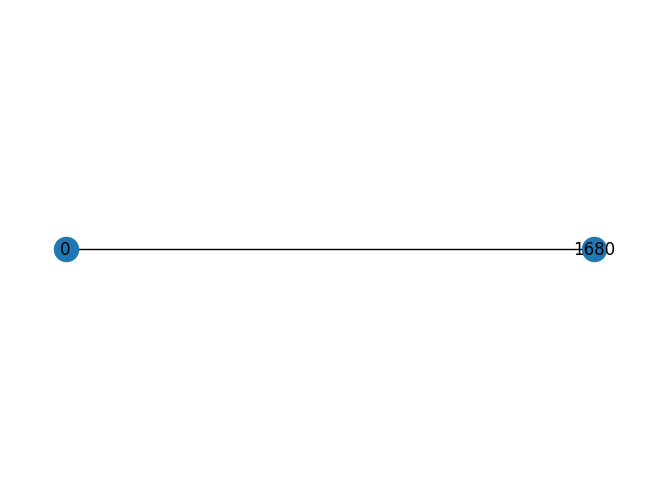

In [29]:
import networkx as nx
nx.draw_planar(g, with_labels=True)

In [31]:
landscape.smad()

0.0